# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q
- Прогнозирование с помощью финальной модели.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from tqdm import tqdm
warnings.filterwarnings('ignore')

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
salary = salary.rename(columns={'WAG_C_M': 'salary'})
salary

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


### 1. Визуальный анализ ряда

- Ряд нестационарен
- Ярковыраженный повышающийся тренд
- Ярковыраженная годовая сезонность
- Отсутствие цикличности
- Дисперсия значений увеличивается во времени

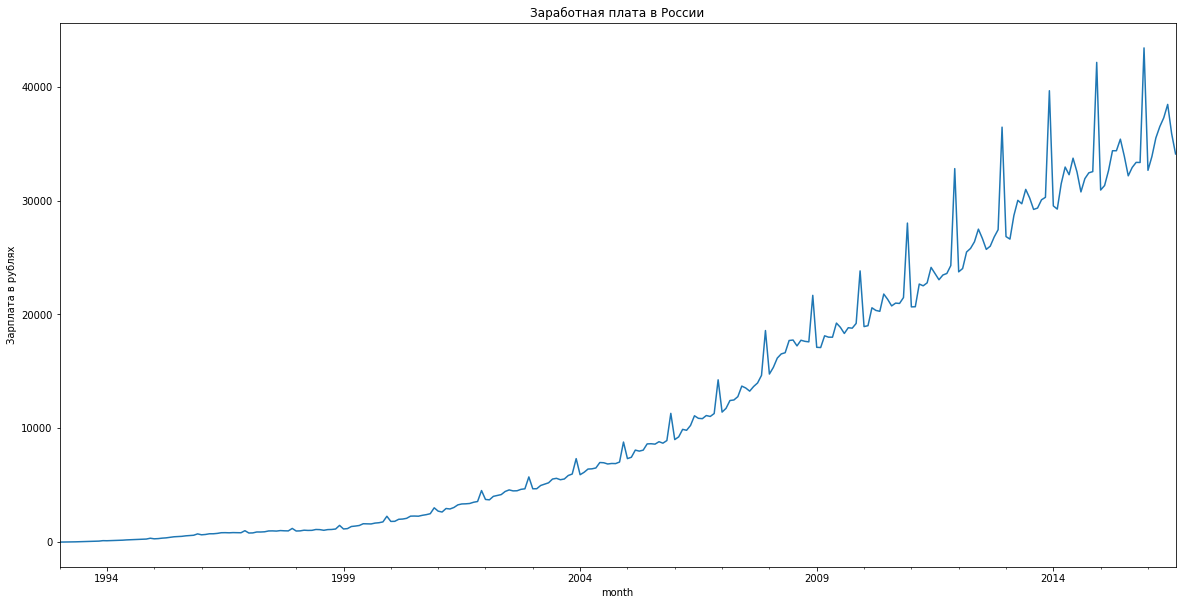

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.title('Заработная плата в России')
plt.xlabel('Год')
plt.ylabel('Зарплата в рублях')
plt.grid()
salary.salary.plot()
pylab.show()

Критерий Дики-Фуллера: p=0.991850


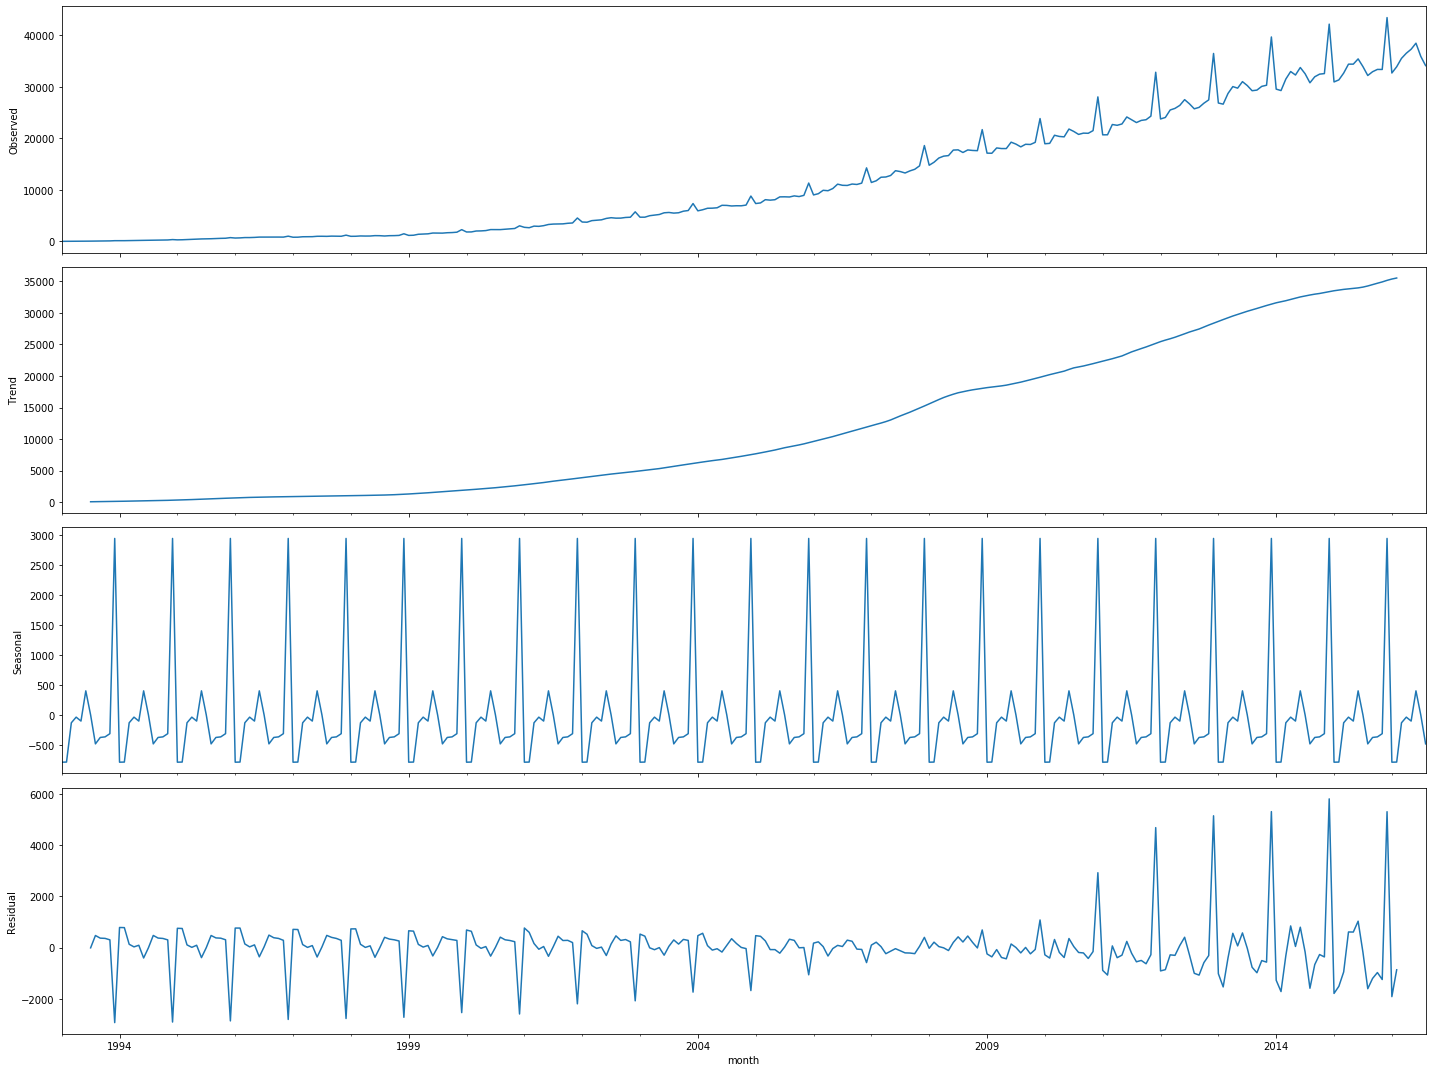

In [4]:
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary)[1])

### 2. Стабилизация дисперсии методом Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


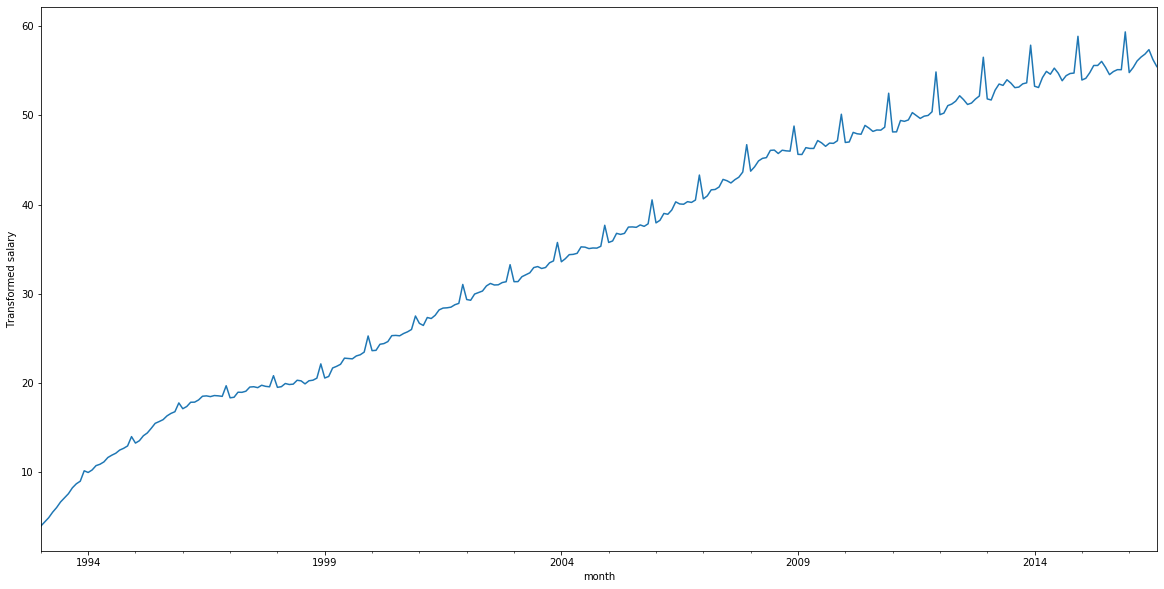

In [5]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary)
plt.rcParams['figure.figsize'] = (20, 10)
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### 3. Выбор порядка дифференцирования

**Проведем сезонное дифференцирование, гипотеза о стационарности отвергается на уровне значимости 0.05, но по графикам видно, что от тренда мы не избавились**

Критерий Дики-Фуллера: p=0.014697


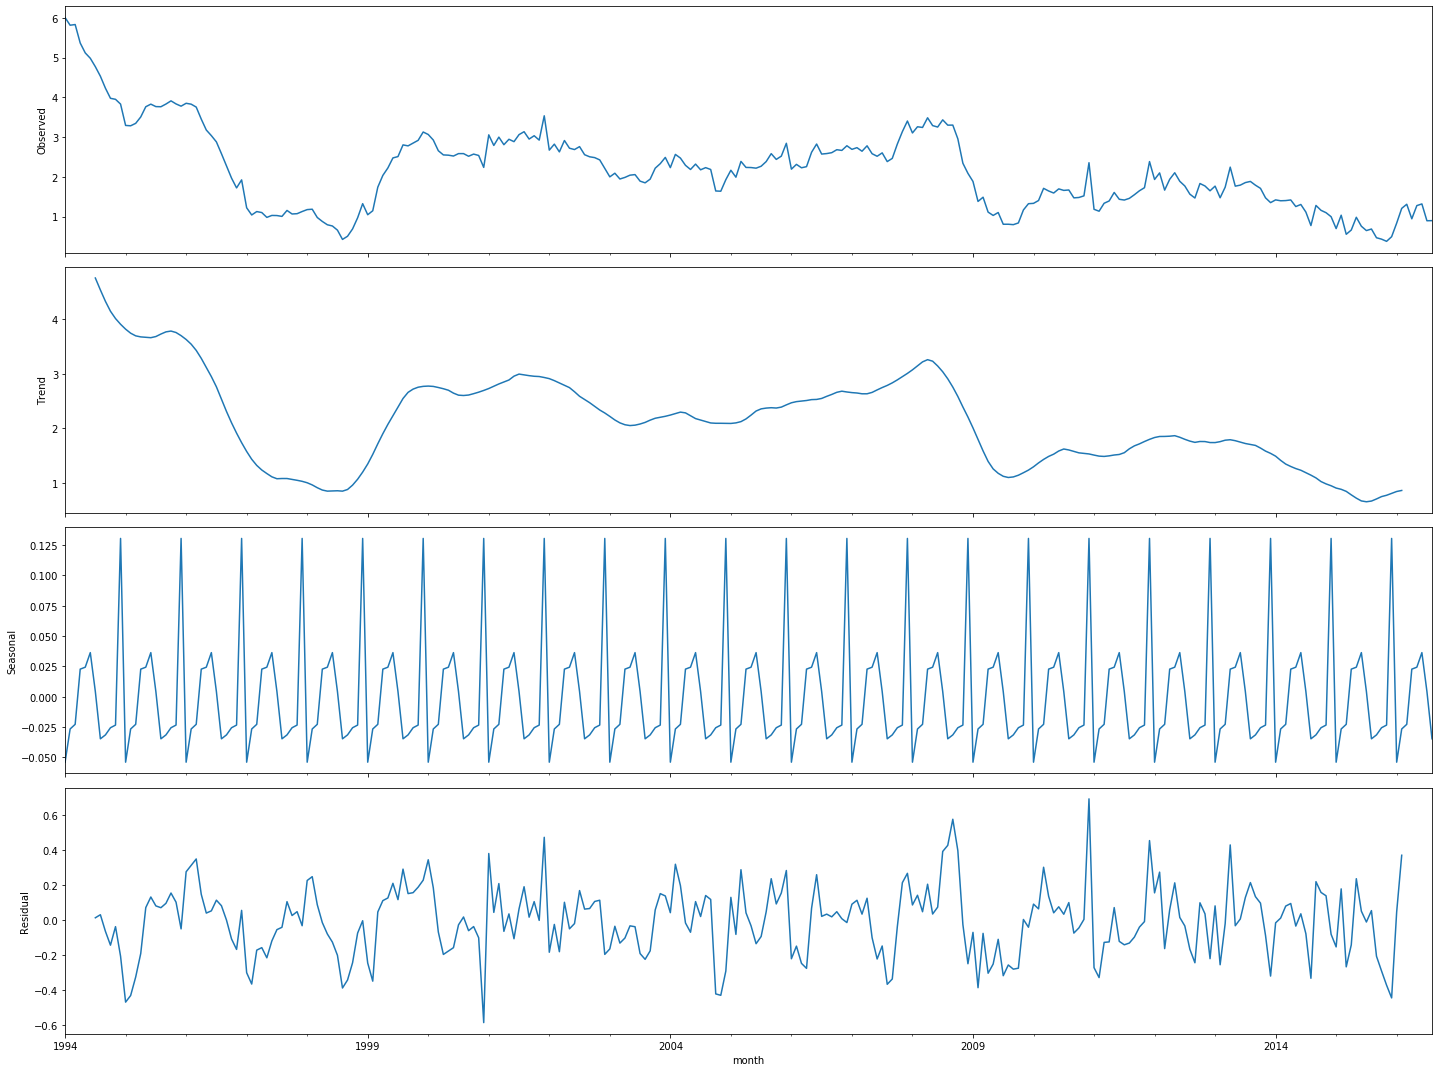

In [6]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary_box_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff.dropna())[1])

**Так как от тренда мы не избавились, проведем дифференцирование еще раз. Теперь уже все, тренда нет, наблюдения и остатки стационарны, критерий Дики-Фулера показывает уверенный 0, графики это подтверждают**

Критерий Дики-Фуллера: p=0.000000


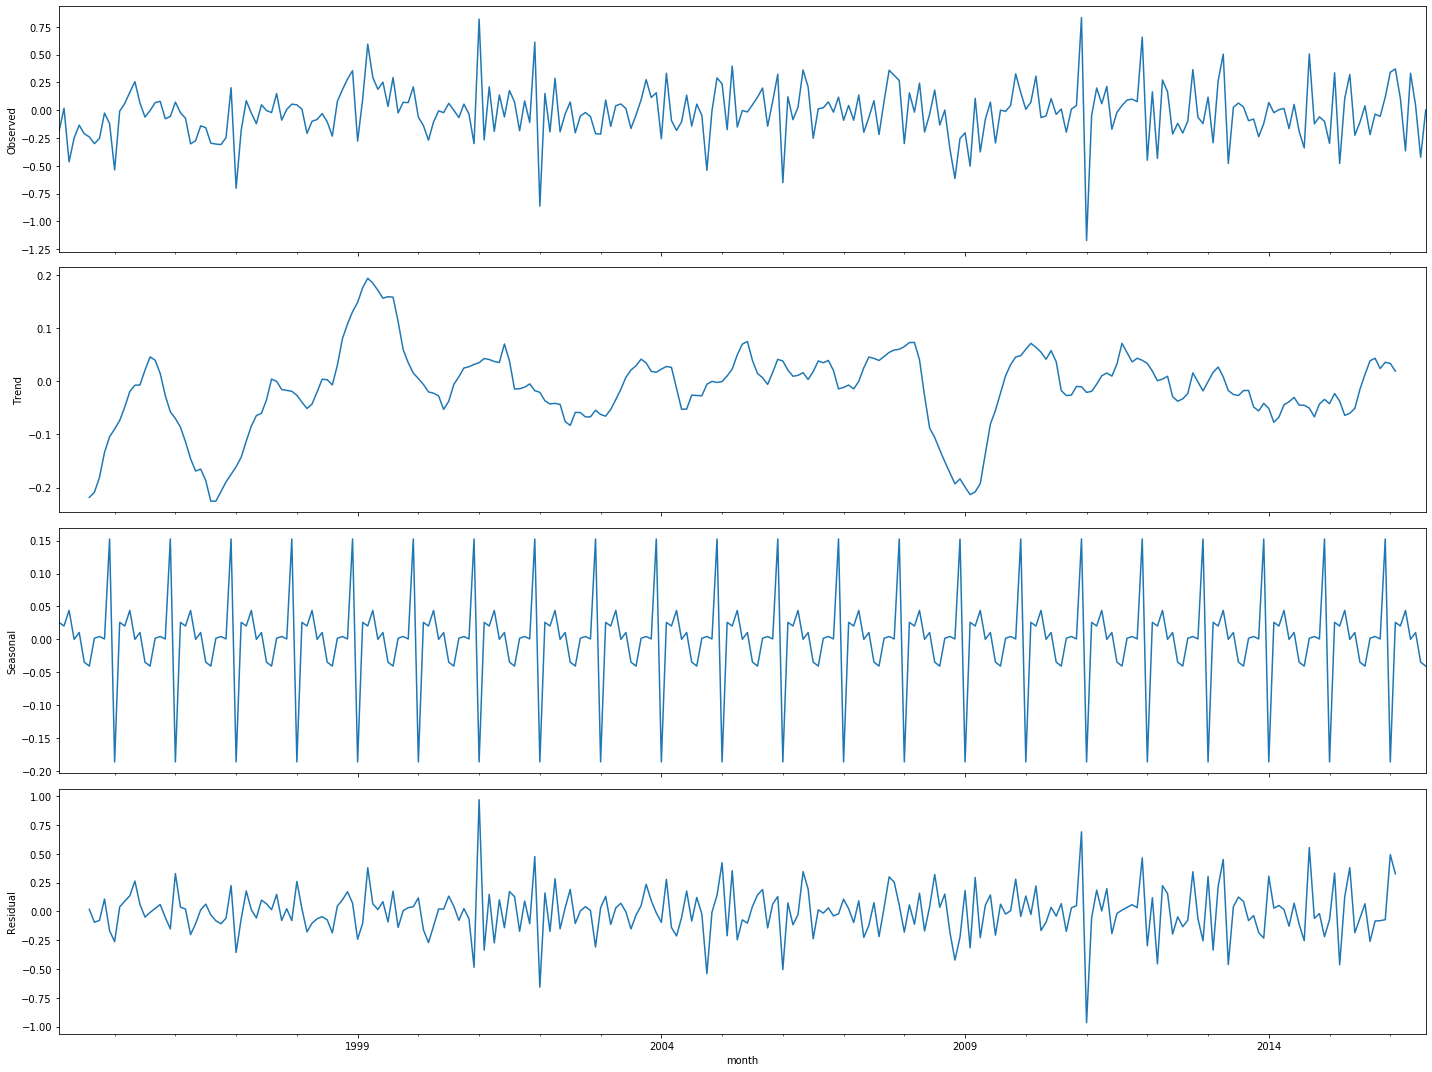

In [7]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.rcParams['figure.figsize'] = (20, 15)
sm.tsa.seasonal_decompose(salary.salary_box_diff2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2.dropna())[1])

### 4. Выбор начальных приближений для p, q, P, Q

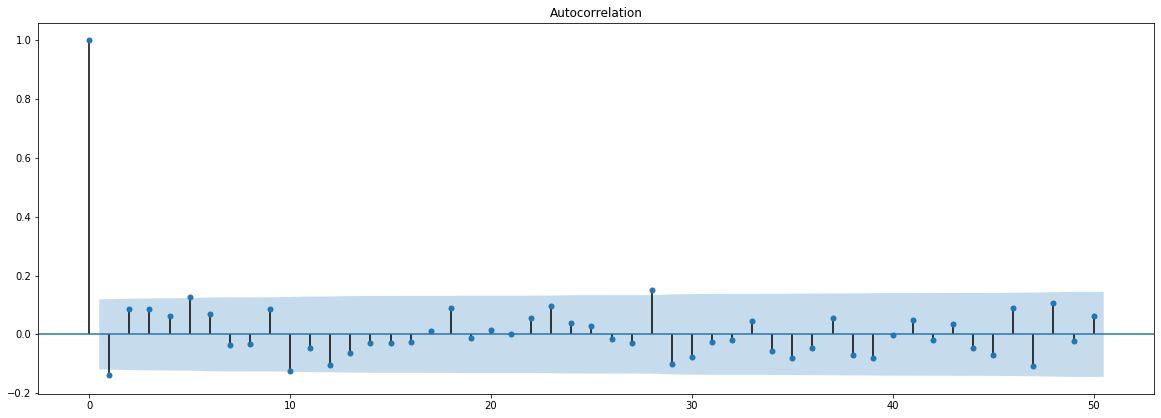

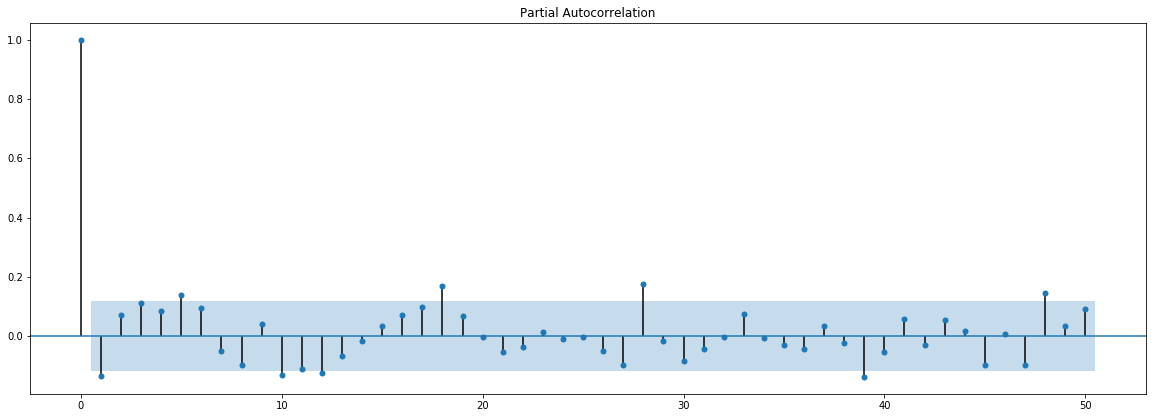

In [8]:
plt.rcParams['figure.figsize'] = (20, 15)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2.dropna(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2.dropna(), lags=50, ax=ax)
pylab.show()

**Начальные приближения: Q=0, q=1, P=1, p=1, но для того, чтобы охватить большее множество параметров, используем бОльшие интервалы для приближений**

In [9]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

### 5. Обучение и сравнение моделей

In [10]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except LinAlgError:
        print('Wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

 98%|█████████▊| 79/81 [01:28<00:03,  1.69s/it]

Wrong parameters: (2, 2, 2, 0)


100%|██████████| 81/81 [01:36<00:00,  1.19s/it]

CPU times: user 5min 48s, sys: 3.75 s, total: 5min 52s
Wall time: 1min 36s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
72  (2, 2, 0, 0) -21.488586
75  (2, 2, 1, 0) -21.473460
73  (2, 2, 0, 1) -21.240103
76  (2, 2, 1, 1) -21.049267
79  (2, 2, 2, 2) -20.907887


In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                  15.744
Date:                            Mon, 16 Dec 2019   AIC                            -21.489
Time:                                    15:51:55   BIC                             -3.478
Sample:                                01-01-1993   HQIC                           -14.257
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4854      0.044     33.922      0.000       1.400       1.571
ar.L2         -0.6837      0.043   

### 6. Анализ остатков построенной модели

**Остатки несмещены (подтверждается критерием Стьюдента на уровне значимости 0.1, но подтверждается полностью по графику) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).**

Критерий Стьюдента: p=0.537394
Критерий Дики-Фуллера: p=0.000000


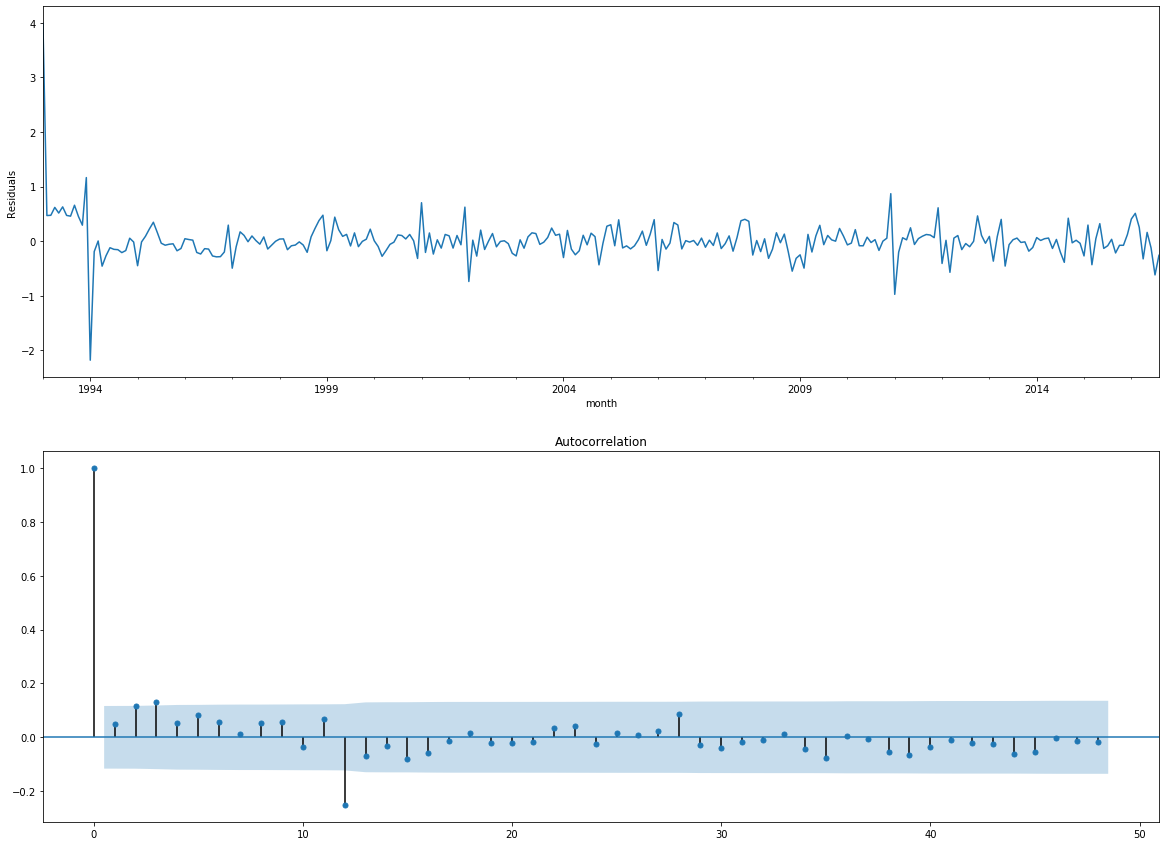

In [13]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

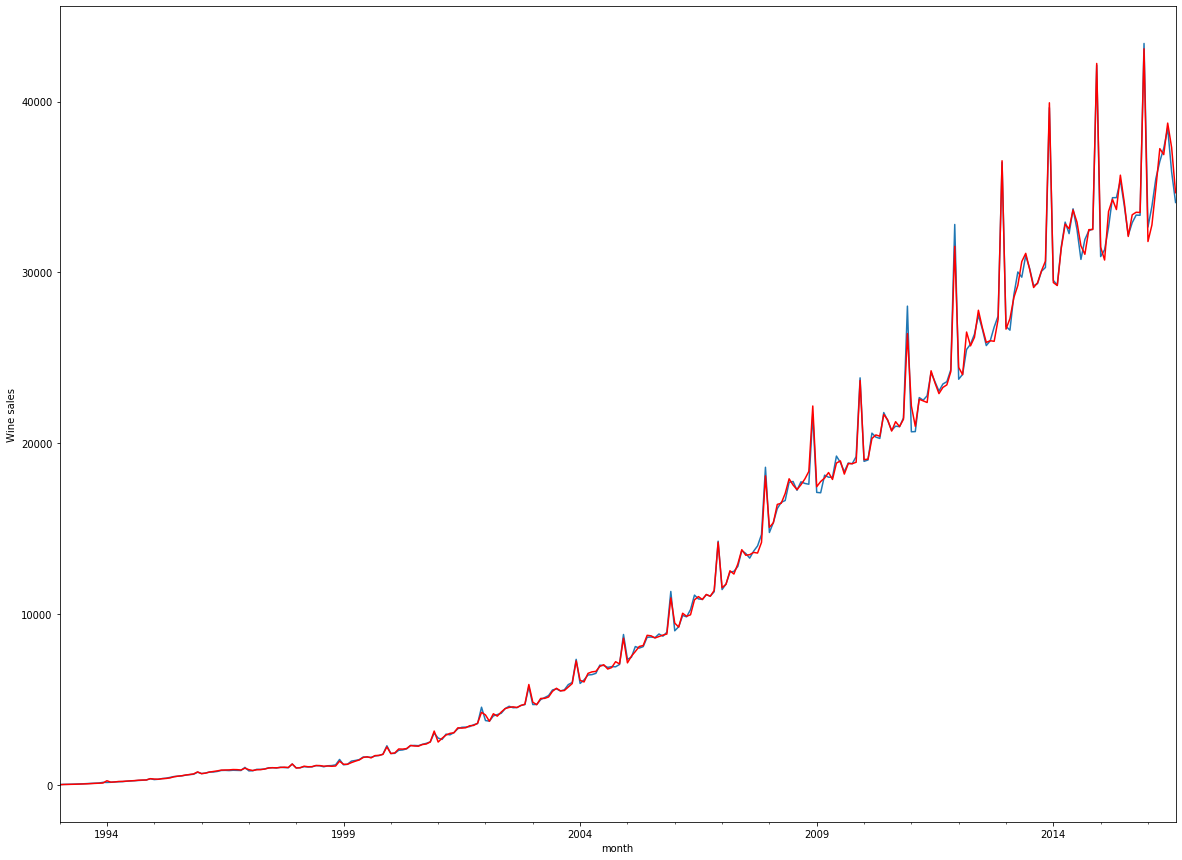

In [14]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams['figure.figsize'] = (20, 15)
salary.salary.plot()
salary.model.dropna().plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### 7. Прогнозирование с помощью финальной модели.

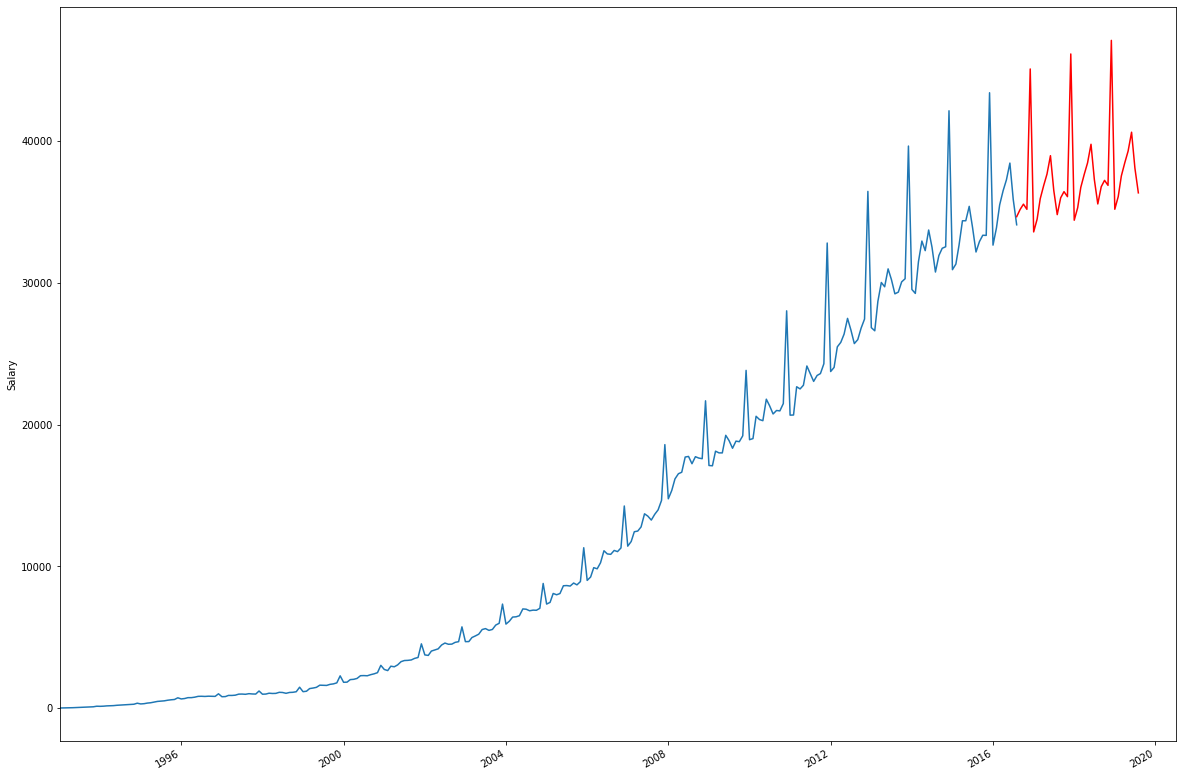

In [15]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=283+36), lmbda)

plt.rcParams['figure.figsize'] = (20, 15)
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

## Спасибо за внимание!